In [1]:
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad

After importing the needed libraries we start by defining the $\chi^2$ which we will need later.

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

Now we just load the txt file with the data and the effective area and then the background.

In [3]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

In [4]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

Now we plot the background.

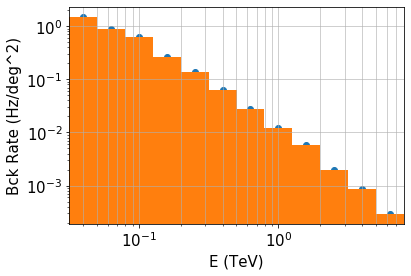

In [5]:
BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))

plt.scatter(BckgElogmean[1:13], Bckg[1:13])
plt.bar(BckgEmin[1:13], Bckg[1:13], width = BckgEdiff[1:13], align = 'edge')
plt.xlim(min(BckgEmin[1:13]), max(BckgEmax[1:13]))
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Bck Rate (Hz/deg^2)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

Here we reproduce the plot from https://www.cta-observatory.org/science/cta-performance/#1472563453568-c1970a6e-2c0f .

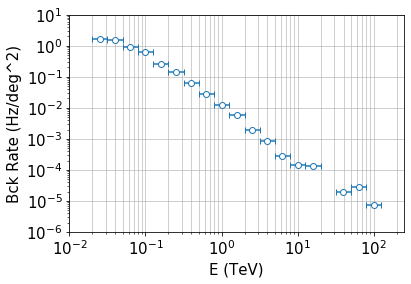

In [6]:
plt.errorbar(BckgElogmean, Bckg, xerr = [BckgElogmean - BckgEmin, BckgEmax - BckgElogmean], capsize=3, fmt='o',mfc='w')
plt.xlim(10**-2, 250)
plt.ylim(10**-6, 10)
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Bck Rate (Hz/deg^2)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

Let's get the background at the same energy bins as the ones of the $\frac{dN}{dE}$. First of all we will make an approximation of the bin width of the $\frac{dN}{dE}$ .

In [7]:
Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

Now we will compute de differential background rate at every bin and interpolate it linearly in the log rate vs log E plot to get the rate at the new bins.

In [68]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
# logDifBckg = np.log10(DifBckg)
# logBckgElogmean = np.log10(BckgElogmean)
# interpolation = interpolate.interp1d(BckgElogmean, DifBckg, fill_value='extrapolate', kind='slinear')
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

Testing with 3 different integration methods:

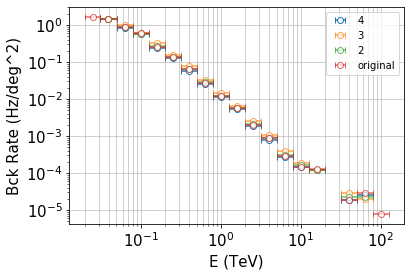

In [69]:
def trapint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation(toplim) + interpolation(bottomlim)) / 2)

def sqint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation((toplim + bottomlim) / 2)))

newlogBckg2 = np.zeros([len(Bckg[1:-1]),2])
for i in range(len(Bckg[1:-1])):
    newlogBckg2[i] = quad(interpolation, BckgEmin[i+1], BckgEmax[i+1])
newlogBckg2 = newlogBckg2[:,0]

newlogBckg3 = trapint(BckgEmax[1:-1], BckgEmin[1:-1])
    
newlogBckg4 = sqint(BckgEmax[1:-1], BckgEmin[1:-1])
    
plt.errorbar(BckgElogmean[1:-1], newlogBckg4, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='4')    
plt.errorbar(BckgElogmean[1:-1], newlogBckg3, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='3', alpha = 0.7)
plt.errorbar(BckgElogmean[1:-1], newlogBckg2, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='2', alpha = 0.7)
# plt.errorbar(BckgElogmean[1:-1], 10**newlogBckg4, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='4')    
# plt.errorbar(BckgElogmean[1:-1], 10**newlogBckg3, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='3', alpha = 0.7)
# plt.errorbar(BckgElogmean[1:-1], 10**newlogBckg2, xerr = [BckgElogmean[1:-1] - BckgEmin[1:-1], BckgEmax[1:-1] - BckgElogmean[1:-1]], capsize=3, fmt='o',mfc='w', label='2', alpha = 0.7)
plt.errorbar(BckgElogmean, Bckg, xerr = [BckgElogmean - BckgEmin, BckgEmax - BckgElogmean], capsize=3, fmt='o',mfc='w', label='original', alpha = 0.7)
# plt.xlim(10**-2, 250)
# plt.ylim(10**-6, 10)
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Bck Rate (Hz/deg^2)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


We can see that all 3 methods fit really good on the data. Now that we have checked that it works, we will try it with the new bins. The best fit is the quad but we will keep using the other ones to check if its correct.

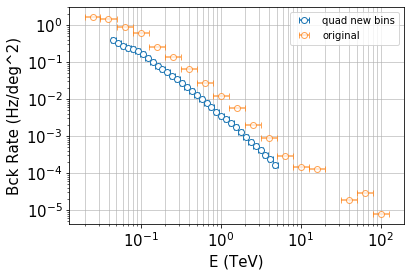

In [125]:
newBckgrate = np.zeros([len(E[3:37]),2])
for i in range(len(E[3:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+3], Ebinsmax[i+3])
newBckgrate = newBckgrate[:,0]

newlogBckg5 = trapint(Ebinsmax[3:37], Ebinsmin[3:37])

newlogBckg6 = sqint(Ebinsmax[3:37], Ebinsmin[3:37])

plt.errorbar(E[3:37], newBckgrate, xerr = [E[3:37] - Ebinsmin[3:37], Ebinsmax[3:37] - E[3:37]], capsize=3, fmt='o',mfc='w', label = 'quad new bins')
# plt.errorbar(E[3:37], newlogBckg5, xerr = [E[3:37] - Ebinsmin[3:37], Ebinsmax[3:37] - E[3:37]], capsize=3, fmt='o',mfc='w', label = 'Trapezoid new bins')
# plt.errorbar(E[3:37], newlogBckg6, xerr = [E[3:37] - Ebinsmin[3:37], Ebinsmax[3:37] - E[3:37]], capsize=3, fmt='o',mfc='w', label = 'Rectangle new bins')
plt.errorbar(BckgElogmean, Bckg, xerr = [BckgElogmean - BckgEmin, BckgEmax - BckgElogmean], capsize=3, fmt='o',mfc='w', label='original', alpha = 0.7)
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Bck Rate (Hz/deg^2)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim(10**-1, 0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

From now on we will use the background obtained with the quad integration method.

The units of the background are $Hz/deg^2$, therefore it is in the same units as our $\frac{dN}{dE}$ except for the $E^-1$

We will simulate 6 backgrounds, one for the background of the source and 5 for the wobbles (using Poisson statistics, instead of simulating it 5 times we will simulate it once with a Poisson parameter 5 times larger and divide it by 5). We will then add the one of the source to the absorved $\frac{dN}{dE}$ and substract it with the ones of the wobbles. This procedure will add a bit of noise and uncertainty, like in the real data.

But first, let's simulate an absorbed $\frac{dN}{dE}$. This time we will use the one of the BL Lac 1ES1011+496 measured by MAGIC in 2014 (but wihtout uncertainty).

In [115]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

Here we will define the Effective area at the same energy bins as the ones of the $\frac{dN}{dE}$ assuming linear behaviour between the bins of the effective area (a valid approximation)

In [116]:
EffaA2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+3] and EffaE[j+10] > E[i+3]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+3] + n

Now we can simulate the background

But first we need the angular resolution at each energy bin.

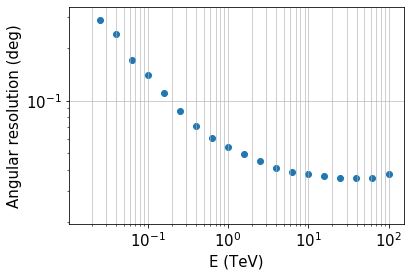

In [117]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()
plt.scatter(AngresE, Angres)
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Angular resolution (deg)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

Let's use the same energy bins as we have used since now. First of all we will do the log of the values to make the fit with thos values. 

In [118]:
logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)

Now we can assume linear behaviour between the points

In [119]:
logAngres2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+3] and logAngresE[j+2] > logE[i+3]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+3] + n
Angres2 = 10**logAngres2

Check if we did it correctly

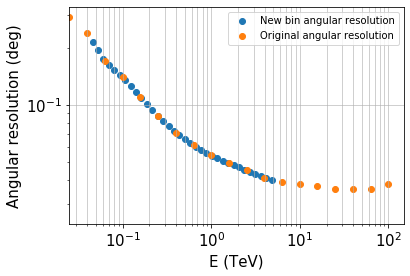

In [120]:
plt.scatter(E[3:37], Angres2, label = 'New bin angular resolution')
plt.scatter(AngresE, Angres, label = 'Original angular resolution')
plt.grid(axis = 'x', which = 'both', alpha=0.75)
plt.grid(axis = 'y', alpha=0.75)
plt.ylabel('Angular resolution (deg)',fontsize=15)
plt.xlabel('E (TeV)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Now that we have checked that the new one is ok, we have to get the angle to a solid angle, using the following formula:

$$\Omega (deg^2) = \bigg(\frac{180}{\pi}\bigg)^2 2\pi(1-cos(\alpha(rad)) $$ 

In [121]:
def degtorad(ang):
    return ang * np.pi / 180

In [126]:
time = 180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

my_generator = np.random.default_rng()
Simbckg1 = my_generator.poisson(bckgmu)
Simbckg1 = Simbckg1.astype(float)
for i in range(len(Simbckg1)):
    if Simbckg1[i] == 0:
        Simbckg1[i] = bckgmu[i]
Simbckg1_u = 1/Simbckg1
Simbckg5 = my_generator.poisson(5*bckgmu)/5
Simbckg5 = Simbckg3.astype(float)
for i in range(len(Simbckg3)):
    if Simbckg5[i] == 0:
        Simbckg5[i] = bckgmu[i]
Simbckg5_u = 1/Simbckg5
#we now get it to the same units as the dN/dE 
Simbckg1_norm = Simbckg1 / time / skyang / (Ebinsmax[3:37] - Ebinsmin[3:37])
Simbckg1_u_norm = Simbckg1_u / time / skyang / (Ebinsmax[3:37] - Ebinsmin[3:37])
Simbckg5_norm = Simbckg5 / time / skyang / (Ebinsmax[3:37] - Ebinsmin[3:37])
Simbckg5_u_norm = Simbckg5_u / time / skyang / (Ebinsmax[3:37] - Ebinsmin[3:37])

Add Poisson noise to the $\frac{dN}{dE}$

In [127]:
mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
N = my_generator.poisson(mu)

for i in range(len(N)):
    if N[i] == 0:
        N[i] = mu[i]

dNdE_p = dNdEa[3:37] * N/mu
dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

After that we will add the background and subtract it using the 5 simulated wobbles (which will add some noise and a lot of uncertainty).

simulated background:
[5.92078972e+01 4.43581112e+01 3.26129692e+01 2.49447346e+01
 1.99936388e+01 1.51046959e+01 1.10507396e+01 7.54657989e+00
 4.86132537e+00 3.16123259e+00 2.56931766e+00 1.77763665e+00
 1.31928392e+00 9.02888626e-01 5.49377601e-01 4.14638827e-01
 2.17852045e-01 2.36458263e-01 1.37410141e-01 6.24110600e-02
 1.94683699e-02 2.73278480e-02 2.12723318e-02 2.74618522e-02
 2.53227415e-02 6.67153100e-03 9.16284731e-03 2.79397590e-03
 1.02232149e-02 1.36679873e-03 9.17202641e-04 1.98218352e-03
 4.02786651e-04 2.50332705e-04]
Difference between 2 bckg:
[-1.36770379e-01 -1.06871867e-01 -3.10150214e-01 -1.03710936e-01
  2.97721292e-01 -1.31589039e-01  2.95199781e-01  3.75065667e-01
  9.55756552e-02 -1.00564799e-01  1.64278623e-01  4.38922631e-02
  5.05725504e-02  1.21251230e-01  2.12937055e-02  3.56003034e-02
 -3.02572284e-02  6.53624466e-02  2.38177578e-02 -1.21354839e-02
 -4.38038322e-02  1.51821378e-03 -9.92708816e-03  1.04616580e-02
  1.32642932e-02  3.33576550e-03  3.05428

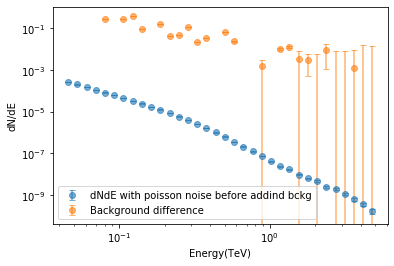

In [129]:
dNdE_b = dNdE_p + (Simbckg1_norm - Simbckg5_norm)
dNdE_b_u = dNdE_p_u + (Simbckg1_u_norm + Simbckg5_u_norm)
print('simulated background:')
print(Simbckg1_norm)
print('Difference between 2 bckg:')
print(Simbckg1_norm - Simbckg3_norm)
print('dNdE:')
print(dNdE_p)
plt.errorbar(E[3:37], dNdE_p, yerr = dNdE_p_u, label='dNdE with poisson noise before addind bckg', capsize=3, fmt='o', alpha=0.6)
#plt.errorbar(E[3:37], dNdE_b, yerr = dNdE_b_u, label='dNdE with poisson noise and subtracted bckg', capsize=3, fmt='o', alpha=0.6)
plt.errorbar(E[3:37], Simbckg1_norm - Simbckg3_norm, yerr = Simbckg1_u_norm + Simbckg3_u_norm, label='Background difference', capsize=3, fmt='o', alpha=0.6)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy(TeV)')
plt.ylabel('dN/dE')
plt.legend()
plt.show()

We transform our $\frac{dN}{dE}$ with the background subtracted into a SED and then the log of the SED, while doing the error propagation.

In [87]:
SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u
logSED = np.log10(SED)
logSED_u = SED_u / (SED * np.log(10))
w = 1/ np.square(logSED_u)

D:\programes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 7.84288261e-05, -1.61892187e-03, -5.37828480e-04, -7.81548722e-04,
        2.24318951e-03,  6.67392427e-04,  6.50223756e-03,  3.48124533e-03,
       -2.69393909e-03,  1.33413271e-03, -8.70276983e-03, -2.04564172e-03,
        3.80509029e-03,  1.77713466e-04,  9.25376091e-04,  4.82471147e-03,
        7.31605944e-03,  9.24341425e-03, -1.65954374e-02, -3.08408121e-03,
        1.81749123e-02, -1.30539587e-02,  1.91046066e-02,  1.07789831e-02,
        2.19615342e-03, -1.87924853e-02, -6.51749668e-03, -3.95196012e-03,
       -7.40518332e-03,  5.82944702e-03, -5.14216116e-03, -5.92832395e-04,
        2.09294708e-02, -6.65678478e-03])